In [1]:
# Ref:https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
from collections import Counter
import random
import ast
import re
import scipy

sys.path.append('pymodules')
# This class contains some utility functions Word2Vec, stop words etc. etc.
import pymodules.preprocessing_class as pc

# gender gueser
import gender_guesser.detector as gd

# for dictionary method synonym finder using wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package wordnet to /Users/bmukund/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/bmukund/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def find_wordnet_synonyms(word_list, type_of_word=None):
    """ it is assumed that the word_list words are themselves synonyms and is given as a list (even if there is only one word
    return lemmatized synonyms ...
    """
    synonyms = set()
    for word_to_look in word_list:
        #print(f"looking for synonyms of word:{word_to_look}")
        for syn in wn.synsets(word_to_look, pos=type_of_word):
            for i in syn.lemmas():
                synonyms.add(i.name())
    #print(f"Synonyms:\n {synonyms}")
    return synonyms

In [3]:
# Function to get the first name so that we can guess the gender
def first_name(x):
    """
    We determine the first name from the given string. We also remove any digits from the name. 
    Further, we use space to split names
    """
    x_split = str(x).split()
    fname = x_split[0]
    # remove reference to digits. Now after removal, there could be some misclassification, but that is ok ..
    fname_p = re.sub(r'[0-9]+', "", fname)
    ret_str = fname_p.capitalize()
    return ret_str


In [4]:
filename = "data/Master-data_Q42021.xlsx"
text_data_raw = pd.read_excel(filename, sheet_name='Scrubbed_data', index_col='REVIEW_DATE')

# We don't need these columns
not_needed = ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE',
'PRODUCT_LINK', 'WEBSITE']

text_data = text_data_raw.drop(columns = not_needed, axis=1)


In [5]:
# Let us figure out the gender from the names and drop the names column
# We use gender_guesser package.
#text_data['AUTHOR'] = text_data['AUTHOR'].astype(str)
gdx = gd.Detector()
text_data['GENDER'] = text_data.AUTHOR.apply(first_name).map(lambda x: gdx.get_gender(x))

# Drop the author column now
text_data.drop(columns = ['AUTHOR'], axis=1, inplace=True)

# Check the gender counts just to see how the data looks like
text_data.GENDER.value_counts()

female           4003
male             2400
unknown          1556
mostly_female     464
mostly_male       253
andy              118
Name: GENDER, dtype: int64

In [6]:
# Consolidate the comments into one column
# Comments can occur both in title and in Comment columns. 
text_data['COMMENT'] = text_data['TITLE'].astype(str).fillna("") + " " + text_data['COMMENTS'].astype(str).fillna("")
text_data.drop(columns = ['TITLE', 'COMMENTS'], axis=1, inplace=True)

In [7]:
# clean rating
# replace N = No rating with 0. We do this because rating is assumed to be numeric, not categorical
text_data['RATING'].replace('N', '0', inplace=True)
# convert rating to integers
text_data['RATING'] = text_data['RATING'].apply(lambda x: int(x))

In [8]:
# display results
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT
REVIEW_DATE,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...
...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic..."
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...


### Tokenization

In [9]:
## regex for tokenization
# Ref: http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py
emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""

# The components of the tokenizer:
regex_strings = (
    # Phone numbers:
    r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?
      \d{3}          # exchange
      [\-\s.]*
      \d{4}          # base
    )"""
    ,
    # Emoticons:
    emoticon_string
    ,
    # HTML tags:
    r"""<[^>]+>"""
    ,
    # Twitter username:
    r"""(?:@[\w_]+)"""
    ,
    # Twitter hashtags:
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
    ,
    # Remaining word types:
    r"""
    (?:[a-z][a-z'\-_]+[a-z])       # Words with apostrophes or dashes.
    |
    (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
    |
    (?:[\w_]+)                     # Words without apostrophes or dashes.
    |
    (?:\.(?:\s*\.){1,})            # Ellipsis dots.
    |
    (?:\S)                         # Everything else that isn't whitespace.
    """,
    r"""
    (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
    \w+(?:-\w+)*        # preserve expressions with internal hyphens as single tokens
    | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
    """
)
word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)

/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_5213/4173119622.py:65: DeprecationWarning: Flags not at the start of the expression '(\n    (?:\n      (?: ' (truncated)
  word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)


In [10]:
comments_data = text_data.COMMENT
prep_comments = pc.RawDocs(comments_data,  # series of documents
                  lower_case=True,  # whether to lowercase the text in the firs cleaning step
                  stopwords='long',  # type of stopwords to initialize
                  contraction_split=True,  # wheter to split contractions or not
                  tokenization_pattern=word_re  # custom tokenization patter
                  )

In [11]:
prep_comments

In [12]:
# notice that the documents from the object are identical to the ones from the pandas series
#comments_data
i = 0
print("Document from the pandas series:\n", comments_data[i])
print("\n-------------------------\n")
print("Document from preprocessing object:\n", prep_comments.docs[i])


Document from the pandas series:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

-------------------------

Document from preprocessing object:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!


In [13]:
# lower-case text, expand contractions and initialize stopwords list
stop_lens_list = ['Lens', 'lens', 'Contact-lens', 'Contact-Lens', 'lenses', 'Lenses', 'Contact-Lenses', 'Contact-lenses', 'contact-lens', 'contact-lenses']
prep_comments.basic_cleaning(custom_stopwords_list = stop_lens_list)

In [14]:
# explore an example after the basic cleaning has been applied
i = 0
print(comments_data[i])
print()
print(prep_comments.docs[i])


Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

acucue 2 contact lenses i have used these lenses for a long time and i have to say that the service from lens.com is great and the lenses work great for my needs!  i highly recommend them!


In [15]:
# now we can split the documents into tokens
prep_comments.tokenize_text()

In [16]:
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])

Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', '2', 'contact', 'lenses', 'i', 'have', 'used', 'these', 'lenses', 'for', 'a', 'long', 'time', 'and', 'i', 'have', 'to', 'say', 'that', 'the', 'service', 'from', 'lens', '.', 'com', 'is', 'great', 'and', 'the', 'lenses', 'work', 'great', 'for', 'my', 'needs', '!', 'i', 'highly', 'recommend', 'them', '!']


In [17]:
punctuation = string.punctuation
punctuation = punctuation.replace("-", "") # remove the hyphen from the punctuation string
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [18]:
prep_comments.token_clean(length=2,                 # remove tokens with less than this number of characters
                 punctuation=punctuation,           # remove custom list of punctuation characters
                 numbers = True                     # remove numbers
                 )


In [19]:
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])


Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', 'contact', 'lenses', 'have', 'used', 'these', 'lenses', 'for', 'long', 'time', 'and', 'have', 'say', 'that', 'the', 'service', 'from', 'lens', 'com', 'great', 'and', 'the', 'lenses', 'work', 'great', 'for', 'needs', 'highly', 'recommend', 'them']


In [20]:
# get the list of stopwords provided earlier
print(sorted(prep_comments.stopwords))

['Contact-Lens', 'Contact-Lenses', 'Contact-lens', 'Contact-lenses', 'Lens', 'Lenses', 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and', 'another', 'any', 'are', 'as', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'contact-lens', 'contact-lenses', 'could', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'even', 'ever', 'every', 'few', 'first', 'five', 'for', 'four', 'from', 'further', 'get', 'go', 'goes', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'high', 'him', 'himself', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'least', 'lens', 'lenses', 'less', 'like', 'long', 'made', 'make', 'many', 'me', 'more', 'most', 'my', 'myself', 'never', 'new', 'no', 'nor', 'not', 'now', 'of', 'off', 'old', 'on', 'once', 'one', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'put', 'said', 'same', 'say', 

In [21]:
# we need to specificy that we want to remove the stopwords from the "tokens"
prep_comments.stopword_remove('tokens')

In [22]:
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])


Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', 'contact', 'used', 'time', 'service', 'com', 'great', 'work', 'great', 'needs', 'highly', 'recommend']


In [23]:
# Build the bigram and trigram models
prep_comments.bigram('tokens')
prep_comments.trigram('tokens')

In [24]:
prep_comments.tokens

[['acucue',
  'contact',
  'used',
  'time',
  'service',
  'com',
  'great',
  'work',
  'great',
  'needs',
  'highly',
  'recommend'],
 ['clear', 'vision', 'tends', 'cloud'],
 ['comfort', 'hard', 'handle', 'flimsy', 'comfortable', 'eye', 'correctly'],
 ['easy', 'use', 'using', 'product', 'years', 'reliable'],
 ['excellent', 'excellent', 'got', 'promised', 'discount', 'chance', 'ask'],
 ['fast',
  'service',
  'can',
  'always',
  'rely',
  'contacts',
  'coming',
  'fast',
  'accurate',
  'thanks',
  'com'],
 ['great', 'brand', 'best', 'brand', 'use', 'contact'],
 ['great', 'experience', 'convenient', 'comfortable', 'affordable'],
 ['service',
  'really',
  'quick',
  'delivery',
  'correct',
  'recommend',
  'using',
  'business'],
 [],
 [],
 ['day', 'acuvue', 'moist', 'pack', 'always', 'receive', 'orders', 'time'],
 ['day', 'acuvue', 'moist', 'pack', 'comfort', 'clarity'],
 ['day', 'acuvue', 'moist', 'pack', 'exactly', 'needed'],
 ['day', 'acuvue', 'moist', 'pack', 'great'],
 ['da

In [25]:
# stemming
# pre_comments.stem()
prep_comments.tokens = prep_comments.tokens + prep_comments.bigrams
# apply lemmatization to all documents (takes a very long time so we will avoid it for now)
prep_comments.lemmatize()

In [26]:
# compare all versions of the same raw sentences
i = -1
print(comments_data[i])
print()
print(prep_comments.tokens[i])
print()
# print(prep_comments.stems[i])
# print()
print(prep_comments.lemmas[i])


Would buy again My order came in fast without any issues, and the candy in the box was a nice touch 😄 

['buy-order', 'order-came', 'came-fast', 'fast-without', 'without-issues', 'issues-candy', 'candy-box', 'box-nice', 'nice-touch']

['buy-order', 'order-came', 'came-fast', 'fast-without', 'without-issues', 'issues-candy', 'candy-box', 'box-nice', 'nice-touch']


In [27]:
# Create Dictionary
id2word = corpora.Dictionary(prep_comments.tokens)

In [28]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in prep_comments.tokens]

In [29]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

In [30]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.013*"great-product" + 0.012*"dry-eyes" + 0.010*"easy-use" + '
  '0.007*"comfortable-easy" + 0.007*"highly-recommend" + 0.005*"great-value" + '
  '0.005*"fast-service" + 0.005*"good-service" + 0.005*"irritate-eyes" + '
  '0.005*"product-great"'),
 (1,
  '0.014*"great-service" + 0.013*"comfortable-wear" + 0.012*"fast-shipping" + '
  '0.010*"fast-delivery" + 0.009*"customer-service" + 0.008*"good-price" + '
  '0.007*"best-price" + 0.007*"easy-order" + 0.007*"acuvue-oasys" + '
  '0.006*"great-quality"'),
 (2,
  '0.003*"acuvue-moist" + 0.003*"came-quickly" + 0.003*"day-acuvue" + '
  '0.003*"fit-clear" + 0.003*"love-product" + 0.003*"easy-process" + '
  '0.003*"cooper-vision" + 0.003*"highly-recommended" + '
  '0.003*"vision-proclear" + 0.002*"excellent-comfortable"'),
 (3,
  '0.017*"great-price" + 0.011*"using-years" + 0.011*"great-contacts" + '
  '0.009*"good-quality" + 0.009*"used-years" + 0.007*"wear-day" + '
  '0.006*"contacts-comfortable" + 0.005*"comfortable-contacts" + '
  

In [31]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    records_list = []
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                records_list.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    out_df = pd.DataFrame.from_records(records_list)
    out_df.columns = ['Dominant_Topic', 'Pct_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    out_df = pd.concat([out_df, contents], axis=1)
    return(out_df)


df_with_topic_r = format_topics_sentences(ldamodel=lda_model,
                                                  corpus=corpus,
                                                  texts=prep_comments.tokens)

# Format the output above with these columns and new data added and label the columns appropriately
df_with_topic = df_with_topic_r.reset_index()
df_with_topic.columns = ['Document_No', 'Dominant_Topic', 'Pct_Contrib_to_Topic', 'Keywords', 'Text']
df_with_topic.head(10)

,Document_No,Dominant_Topic,Pct_Contrib_to_Topic,Keywords,Text
0,0,2,0.9232,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[acucue, contact, used, time, service, com, gr..."
1,1,2,0.8004,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[clear, vision, tends, cloud]"
2,2,2,0.8754,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[comfort, hard, handle, flimsy, comfortable, e..."
3,3,2,0.8575,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[easy, use, using, product, years, reliable]"
4,4,2,0.8754,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[excellent, excellent, got, promised, discount..."
5,5,2,0.9168,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[fast, service, can, always, rely, contacts, c..."
6,6,2,0.8575,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[great, brand, best, brand, use, contact]"
7,7,2,0.8338,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[great, experience, convenient, comfortable, a..."
8,8,2,0.8892,"acuvue-moist, came-quickly, day-acuvue, fit-cl...","[service, really, quick, delivery, correct, re..."
9,9,0,0.2500,"great-product, dry-eyes, easy-use, comfortable...",[]


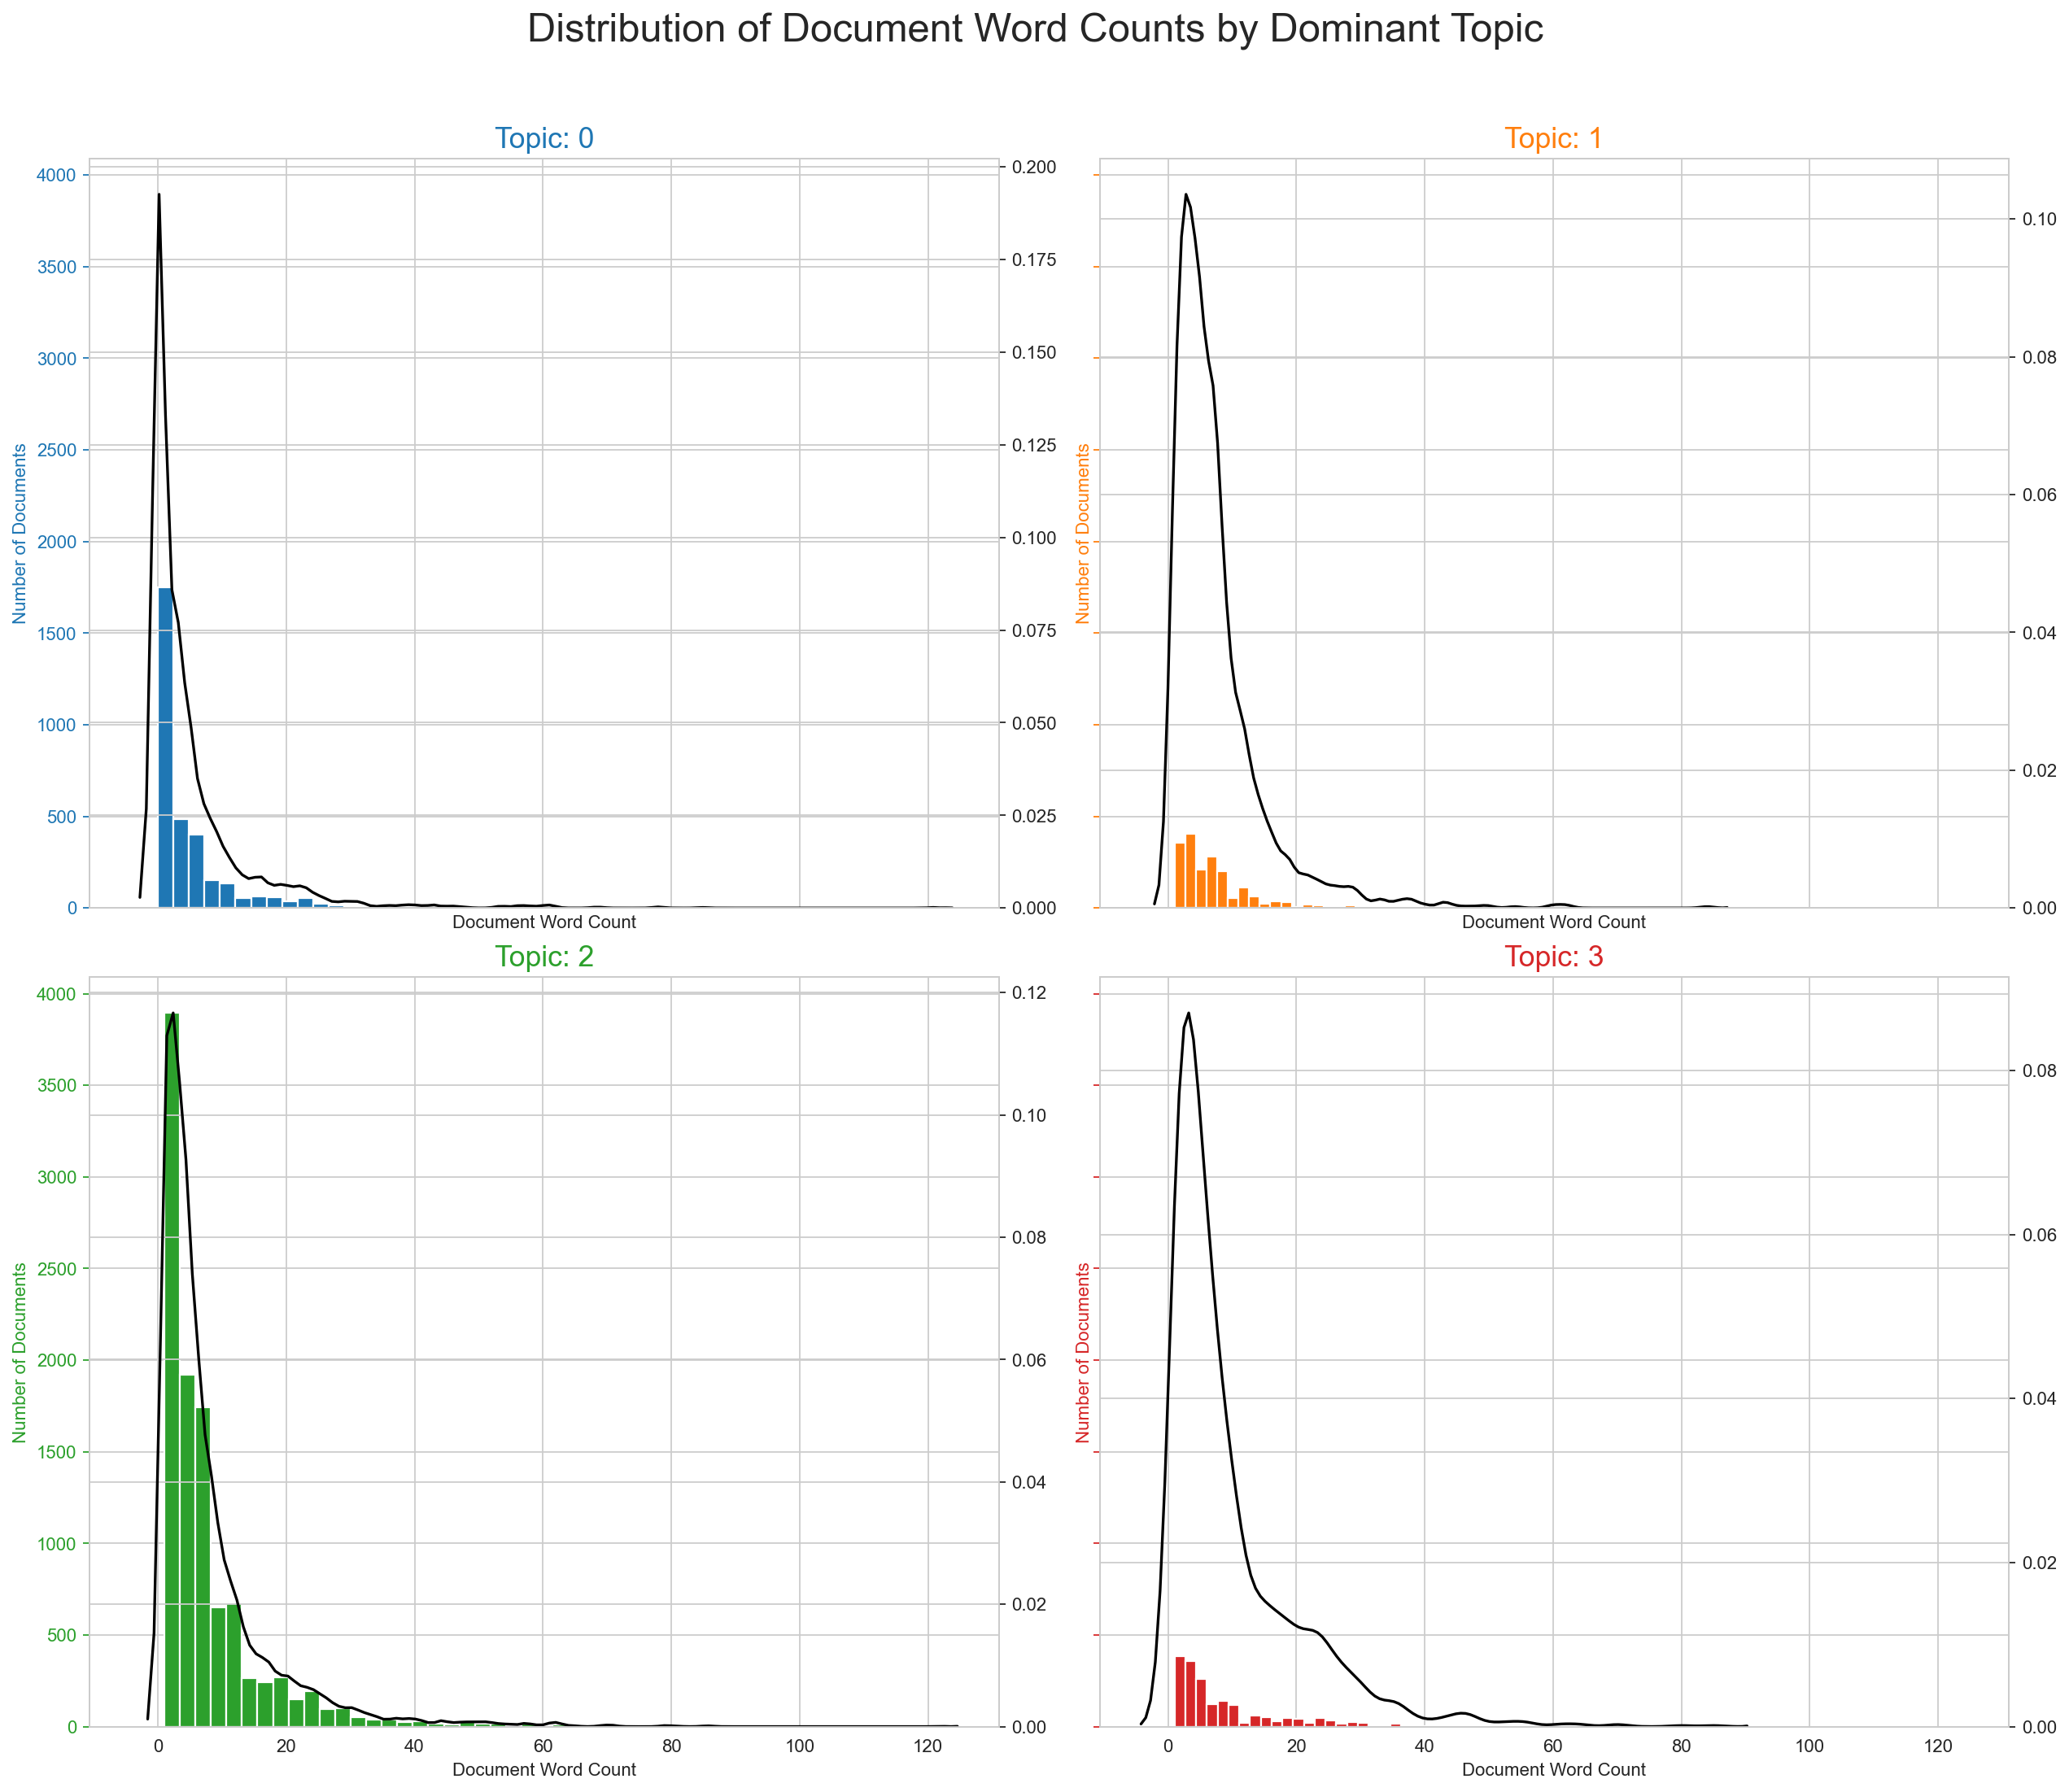

In [32]:
import matplotlib.colors as mcolors
import math
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex='all', sharey='all')

for i, ax in enumerate(axes.flatten()):
    df_with_topic_sub = df_with_topic.loc[df_with_topic.Dominant_Topic == i, :]
    doc_lengths = np.array([len(d) for d in df_with_topic_sub.Text])
    plt_data = doc_lengths
    ax.hist(plt_data, bins = 50, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    # note the twin x
    sns.kdeplot(plt_data, color="black", shade=False, ax=ax.twinx())
    #ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_xlabel('Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_5213/551647997.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_5213/551647997.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_5213/551647997.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_5213/551647997.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= '

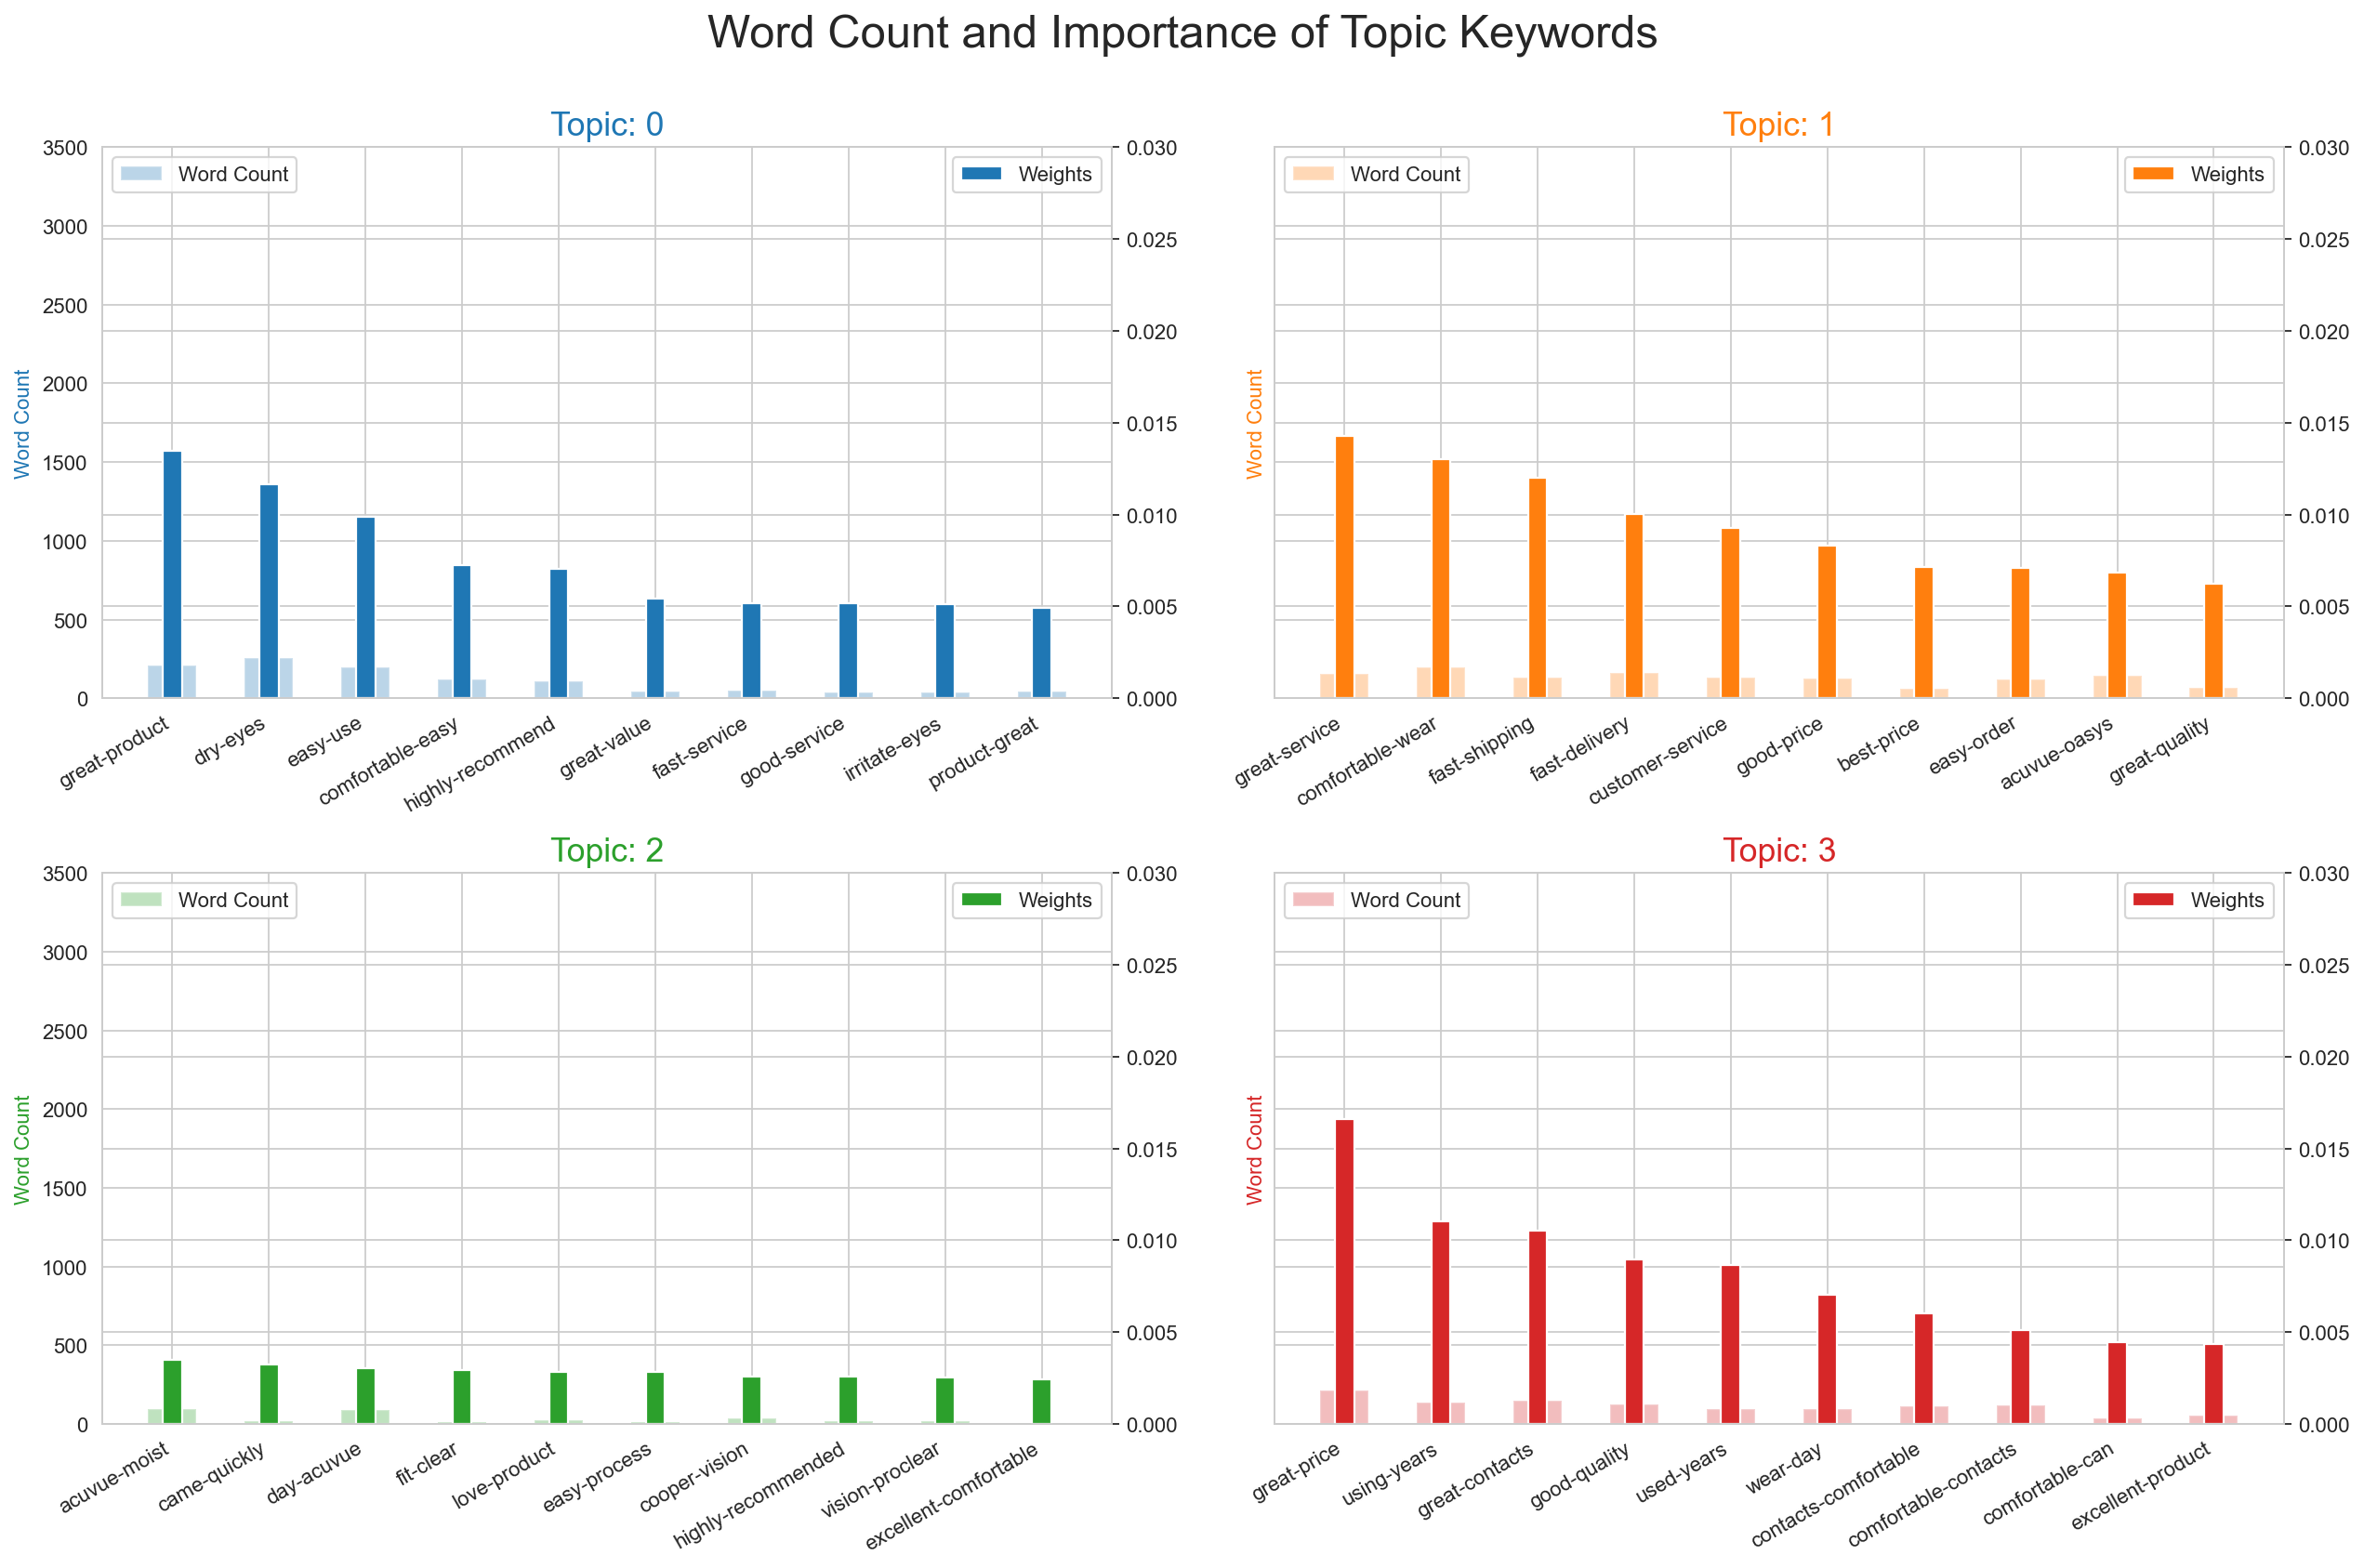

In [38]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in prep_comments.tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey='all', dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

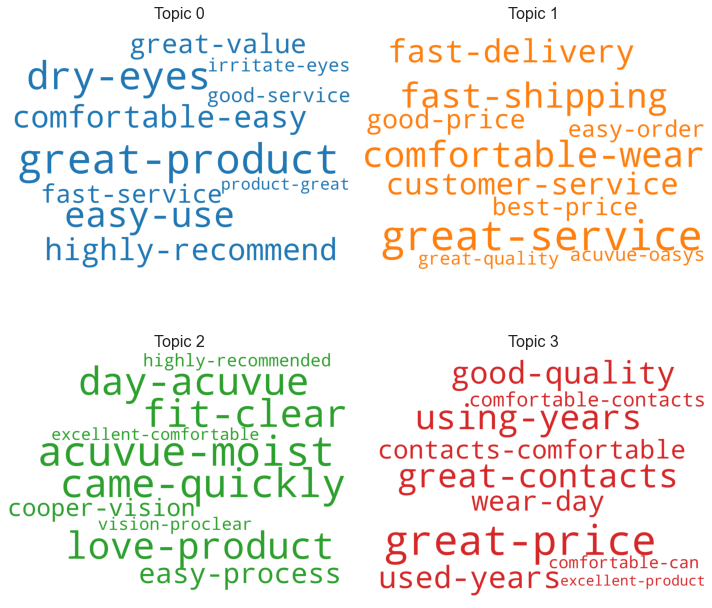

In [33]:
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=prep_comments.stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex='all', sharey='all')

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### What are the most discussed topics in the documents?

In [34]:
### What are the most discussed topics in the documents?
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return (dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                   for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

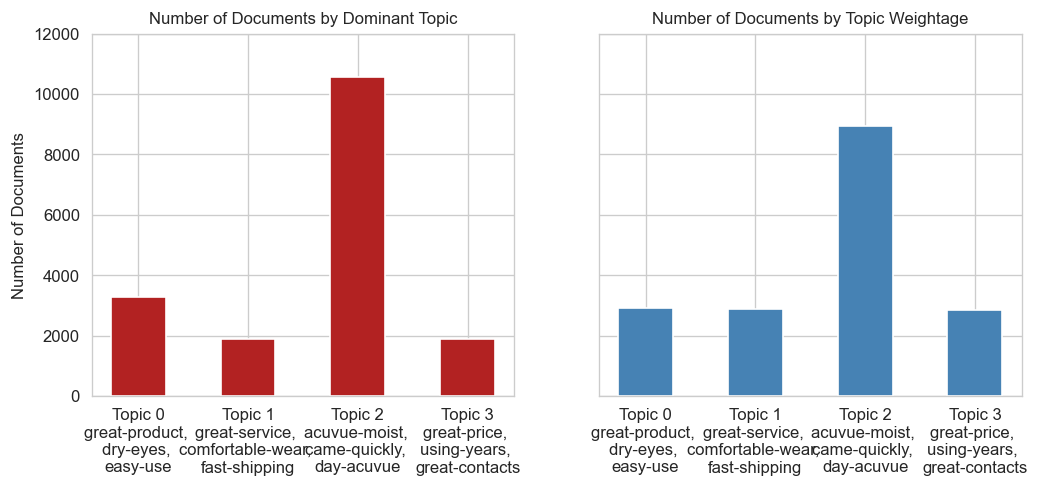

In [35]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey='all')

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 12000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [36]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/bmukund/miniconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.045306  0.223357       1        1  57.764894
3      0.098755 -0.112066       2        1  15.006368
0      0.104242 -0.075696       3        1  14.230881
1     -0.248303 -0.035595       4        1  12.997857, topic_info=                         Term        Freq       Total Category  logprob  \
4133              great-price  328.000000  328.000000  Default  30.0000   
4352            great-service  244.000000  244.000000  Default  29.0000   
4134            great-product  252.000000  252.000000  Default  28.0000   
4019         comfortable-wear  223.000000  223.000000  Default  27.0000   
4014                 dry-eyes  219.000000  219.000000  Default  26.0000   
...                       ...         ...         ...      ...      ...   
4470             acuvue-oasys  117.075146  133.873395   Topic4  -4.9827   
4012   comfortable-convenient   56.128946   58.845158   Topic4  -5.7179   
5341            great-company   53.235189   56.276578   Topic4  -5.7708   
10610             acuvue-vita   68.518486   97.013499   Topic4  -5.5184   
28522       continue-ordering   68.949992  112.933874   Topic4  -5.5122   

       loglift  
4133   30.0000  
4352   29.0000  
4134   28.0000  
4019   27.0000  
4014   26.0000  
...        ...  
4470    1.9063  
4012    1.9931  
5341    1.9848  
10610   1.6926  
28522   1.5470  

[181 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
3930       1  0.997426  acuvue-moist
4470       1  0.126986  acuvue-oasys
4470       4  0.873960  acuvue-oasys
10610      1  0.030924   acuvue-vita
10610      2  0.185541   acuvue-vita
...      ...       ...           ...
3883       3  0.982590    work-great
8081       1  0.994692     work-work
9226       1  0.999577   works-great
7434       1  0.016317    years-find
7434       2  0.979044    years-find

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])